In [1]:
import os
from pathlib import Path
from typing import Annotated

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
from einops import rearrange, repeat
from sklearn.cluster import KMeans
from skimage.color import label2rgb
from sklearn.neighbors import radius_neighbors_graph

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
output_dir = Path('../data/cell_type_grid_analysis_for_julia_v2')
output_dir.mkdir(parents=True, exist_ok=True)

In [25]:
meta = pd.read_csv(
    '/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/JW_workspace/IRD_xenium_analysis_2/annotations/annot_xenium_paths.txt',
    sep='\t',
    index_col=0
)
meta

,UPN,UPN_Sample,annotation_csv,Output.file.path
Sample,,,,
IRD_S18-30740A1U3,WU108,WU108_IRD_S18-30740A1U3,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20240821__204457_...
S11-3564A1U1,14926,14926_S11-3564A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250116__195216_...
S13-35096A1U1,10483,10483_S13-35096A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250113__211232_...
S13-47674A1U1,21167,21167_S13-47674A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250113__211232_...
S14-11561A1U1,20799,20799_S14-11561A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20241221__004049_...
...,...,...,...,...
SP126U1-A1-S1Fp1U1,WU107,WU107_SP126U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250530__173331_...
SP127U1-A1-S1Fp1U1,WU007,WU007_SP127U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250620__162328_...
SP129U1-A1-S1Fp1U1,WU030,WU030_SP129U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250620__162328_...


In [26]:
for sid, row in meta.iterrows():
    print(sid)
    spaceranger_dir = Path(row['Output.file.path'])
    assert spaceranger_dir.is_dir(), f'{spaceranger_dir} is not a directory.'
    cell_df = pd.read_parquet(spaceranger_dir / 'cells.parquet').set_index('cell_id')
    
    annotation_df = pd.read_csv(row['annotation_csv'], index_col=0)
    cell_df = cell_df.loc[annotation_df.index]
    
    annots = annotation_df['group'].values
    cell_types = sorted(set(annots))
    
    # neighbors graph
    graph = radius_neighbors_graph(cell_df[['x_centroid', 'y_centroid']].values, 200)
    
    # tally counts
    data = []
    for i in range(graph.shape[0]):
        nbhrs = annots[graph[i].indices]
        labels, counts = np.unique(nbhrs, return_counts=True)
        mapping = {k: v for k, v in zip(labels, counts)}
        data.append([mapping.get(cell_type, 0) for cell_type in cell_types])
    count_df = pd.DataFrame(data=data, columns=cell_types, index=cell_df.index)
    count_df['total_count'] = count_df.sum(1)
    
    # calculate fractions
    X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]
    frac_df = pd.DataFrame(X, columns = cell_types, index = count_df.index)
    frac_df.insert(0, 'y', cell_df['y_centroid'])
    frac_df.insert(0, 'x', cell_df['x_centroid'])
    frac_df['total_count'] = count_df['total_count']
    
    frac_df.to_csv(output_dir / f'{sid}_fractions.txt', sep='\t')
    count_df.to_csv(output_dir / f'{sid}_counts.txt', sep='\t')

IRD_S18-30740A1U3


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S11-3564A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S13-35096A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S13-47674A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-11561A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-14053A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-14053A1U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-18864-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-22950-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S14-9876A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S15-15758-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S16-26183A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S16-30080A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S17-24784A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S17-24784A1U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S17-32736-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S17-34578-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S17-5570A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S18-36373A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S18-461-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S18-6148A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S19-25371-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S20-2375-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S21-1209-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S21-19998-A1U1Q1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S21-19998-A1U1Q2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S22-3386-A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


S24-19138A1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN113R1-Ma1Fd2-2U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN126F1-Ma1Fd2-4U3


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN131R1-Ma1Fd2-12U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN151R1-Ma1Fd2-2U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN154R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN160R1-Ma1Fd2-15U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN161R1-Ma1Fd2-3U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN169R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN174R1-14U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN198R1-Ma1Fd2-1U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN200R1-Ma1Fd2-1U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN203R1-Ma1Fd2-2U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN207R1-Ma1Fd2-1U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN209R1-Ma1Fd2-2U2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN215R1-Ma1Fd2P-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN218R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN219R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN221R1-Ma1Fd2P-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN222R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN222R1-Ma1Fd2P-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN224R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN225R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN227R1-Ma1Fd2-2U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SN228R1-Ma1Fd2-1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP110U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP112U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP113U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP114U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP115U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP117U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP118U1-A1-S1Fp1U1Q1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP118U1-A1-S1Fp1U1Q2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP119U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP120U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP121U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP125U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP126U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP127U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP129U1-A1-S1Fp1U1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP130U1-A1-S1Fp1U1Q1


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


SP130U1-A1-S1Fp1U1Q2


/diskmnt/Users2/estorrs/tmp/ipykernel_98105/94512441.py:27: RuntimeWarning: invalid value encountered in divide
  X = count_df.values[:, :-1] / count_df['total_count'].values[:, None]


## K means clusters analysis

In [28]:
paths = [path for path in output_dir.rglob('*') if '_fractions.txt' in path.name]
paths

[PosixPath('../data/cell_type_grid_analysis_for_julia_v2/IRD_S18-30740A1U3_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/SN203R1-Ma1Fd2-2U2_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/S18-36373A1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/S17-24784A1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/SP125U1-A1-S1Fp1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/S14-11561A1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/S19-25371-A1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/SN221R1-Ma1Fd2P-1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/SP119U1-A1-S1Fp1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/S14-14053A1U1_fractions.txt'),
 PosixPath('../data/cell_type_grid_analysis_for_julia_v2/SN200R1-Ma1Fd2-1U2_fractions.txt'),
 

In [29]:
dfs = []
for path in paths:
    sid = path.name.replace('_fractions.txt', '')
    print(sid)
    df = pd.read_csv(path, sep='\t', index_col=0)
    df.insert(0, 'sid', [sid] * df.shape[0])
    df.index = [f'{sid}_{barcode}' for barcode in df.index]
    dfs.append(df)
fractions = pd.concat(dfs, axis=0)
fractions 

IRD_S18-30740A1U3
SN203R1-Ma1Fd2-2U2
S18-36373A1U1
S17-24784A1U1
SP125U1-A1-S1Fp1U1
S14-11561A1U1
S19-25371-A1U1
SN221R1-Ma1Fd2P-1U1
SP119U1-A1-S1Fp1U1
S14-14053A1U1
SN200R1-Ma1Fd2-1U2
SP118U1-A1-S1Fp1U1Q1
S11-3564A1U1
SP110U1-A1-S1Fp1U1
S21-19998-A1U1Q1
S15-15758-A1U1
SN227R1-Ma1Fd2-2U1
SN219R1-Ma1Fd2-1U1
S14-22950-A1U1
SN151R1-Ma1Fd2-2U1
SP112U1-A1-S1Fp1U1
SP130U1-A1-S1Fp1U1Q1
SN225R1-Ma1Fd2-1U1
SN131R1-Ma1Fd2-12U1
S20-2375-A1U1
SP126U1-A1-S1Fp1U1
SP113U1-A1-S1Fp1U1
SN224R1-Ma1Fd2-1U1
S13-35096A1U1
SN215R1-Ma1Fd2P-1U1
SP127U1-A1-S1Fp1U1
S17-34578-A1U1
SN126F1-Ma1Fd2-4U3
S21-1209-A1U1
S24-19138A1U1
SN218R1-Ma1Fd2-1U1
SN209R1-Ma1Fd2-2U2
S14-18864-A1U1
S14-9876A1U1
S17-24784A1U2
SN198R1-Ma1Fd2-1U2
S14-14053A1U2
SP117U1-A1-S1Fp1U1
SP118U1-A1-S1Fp1U1Q2
SN161R1-Ma1Fd2-3U1
S21-19998-A1U1Q2
SN207R1-Ma1Fd2-1U2
SN228R1-Ma1Fd2-1U1
SN113R1-Ma1Fd2-2U2
SP115U1-A1-S1Fp1U1
SN160R1-Ma1Fd2-15U1
SN222R1-Ma1Fd2-1U1
S13-47674A1U1
S17-5570A1U1
SP121U1-A1-S1Fp1U1
SP129U1-A1-S1Fp1U1
SP130U1-A1-S1Fp1U1Q2
SN1

,sid,x,y,B,Erythroid,MKC,Myeloid,PC,Progenitor,Stromal,T/NK,pDC,total_count
IRD_S18-30740A1U3_aaaefkpp-1,IRD_S18-30740A1U3,433.430206,1357.545288,0.027027,0.372587,0.0,0.233591,0.225869,0.123552,0.000000,0.015444,0.001931,518
IRD_S18-30740A1U3_aaaekejm-1,IRD_S18-30740A1U3,449.853851,1278.230225,0.024390,0.383592,0.0,0.232816,0.228381,0.117517,0.000000,0.011086,0.002217,451
IRD_S18-30740A1U3_aaaekekb-1,IRD_S18-30740A1U3,438.366547,1361.509277,0.026871,0.376200,0.0,0.232246,0.226488,0.122841,0.000000,0.013436,0.001919,521
IRD_S18-30740A1U3_aaaeonma-1,IRD_S18-30740A1U3,438.007660,1311.078979,0.028455,0.371951,0.0,0.231707,0.233740,0.117886,0.000000,0.014228,0.002033,492
IRD_S18-30740A1U3_aaaflkno-1,IRD_S18-30740A1U3,373.216797,1557.585327,0.024221,0.314879,0.0,0.266436,0.266436,0.103806,0.003460,0.020761,0.000000,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP120U1-A1-S1Fp1U1_oidolakm-1,SP120U1-A1-S1Fp1U1,8591.683594,978.785095,0.034843,0.213705,0.0,0.314750,0.037166,0.222997,0.123113,0.051103,0.002323,861
SP120U1-A1-S1Fp1U1_oieagbcp-1,SP120U1-A1-S1Fp1U1,8611.003906,991.261047,0.036755,0.223067,0.0,0.295311,0.038023,0.220532,0.126743,0.057034,0.002535,789
SP120U1-A1-S1Fp1U1_oiebdpfk-1,SP120U1-A1-S1Fp1U1,8483.833984,964.089783,0.037855,0.192429,0.0,0.374343,0.031546,0.216614,0.111462,0.033649,0.002103,951
SP120U1-A1-S1Fp1U1_oiebipkn-1,SP120U1-A1-S1Fp1U1,8484.653320,973.849426,0.037234,0.194681,0.0,0.371277,0.031915,0.220213,0.107447,0.035106,0.002128,940


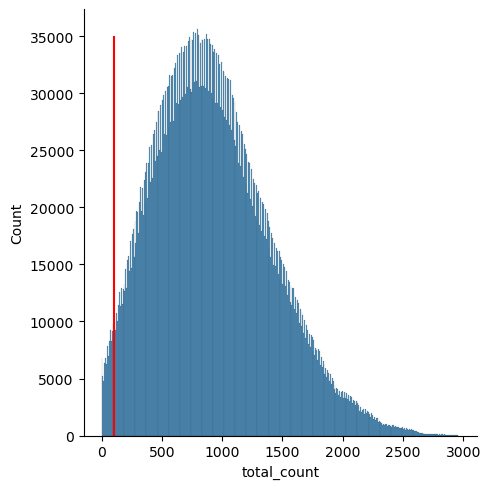

In [31]:
# we'll use the same cutoff as previous section
thresh = 100

sns.displot(fractions['total_count'])
plt.vlines(thresh, ymin=0, ymax=35000, colors='red')

filter out low cellularity grids

In [32]:
fractions = fractions[fractions['total_count']>=thresh]
fractions.shape

(5234894, 13)

do k-means clustering

In [33]:
n_clusters = 10
model = KMeans(n_clusters=n_clusters)
X = fractions[[c for c in fractions.columns if c not in ['total_count', 'sid', 'x', 'y']]].values
X[pd.isnull(X)] = 0

dists = model.fit_transform(X)
clusters = dists.argmin(1)

dists.shape, clusters.shape

((5234894, 10), (5234894,))

In [34]:
dists[0], clusters[0]

(array([0.36395034, 0.69342048, 0.26036431, 0.36848917, 0.40802665,
        0.22197394, 0.3297103 , 0.17990967, 0.53434361, 0.49936166]),
 np.int64(7))

In [35]:
fractions['cluster'] = clusters

/diskmnt/Users2/estorrs/tmp/ipykernel_98105/3488209560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fractions['cluster'] = clusters


average fraction for each cluster

In [36]:
source = fractions[[c for c in fractions.columns if c not in ['total_count', 'sid', 'x', 'y']]].copy()
grouped = source.groupby('cluster').mean()
grouped

,B,Erythroid,MKC,Myeloid,PC,Progenitor,Stromal,T/NK,pDC
cluster,,,,,,,,,
0,0.040420,0.145533,0.000541,0.402422,0.047227,0.244506,0.070184,0.042426,0.006748
1,0.025894,0.025002,0.000111,0.041897,0.785539,0.039585,0.054244,0.023630,0.004103
2,0.067462,0.259677,0.000663,0.301396,0.038906,0.215816,0.067930,0.041174,0.006981
3,0.040007,0.150864,0.000473,0.271618,0.055649,0.340644,0.089403,0.044818,0.006527
4,0.176652,0.099896,0.000466,0.178802,0.073320,0.170437,0.188321,0.088239,0.023883
5,0.030775,0.187087,0.000616,0.222475,0.213344,0.211897,0.072436,0.056745,0.004654
6,0.048842,0.117970,0.000334,0.150858,0.396163,0.158735,0.072646,0.049602,0.004863
7,0.048961,0.384500,0.000536,0.220563,0.067657,0.170667,0.059340,0.042600,0.005191
8,0.019023,0.087158,0.000247,0.269339,0.028300,0.525491,0.045357,0.021550,0.003535


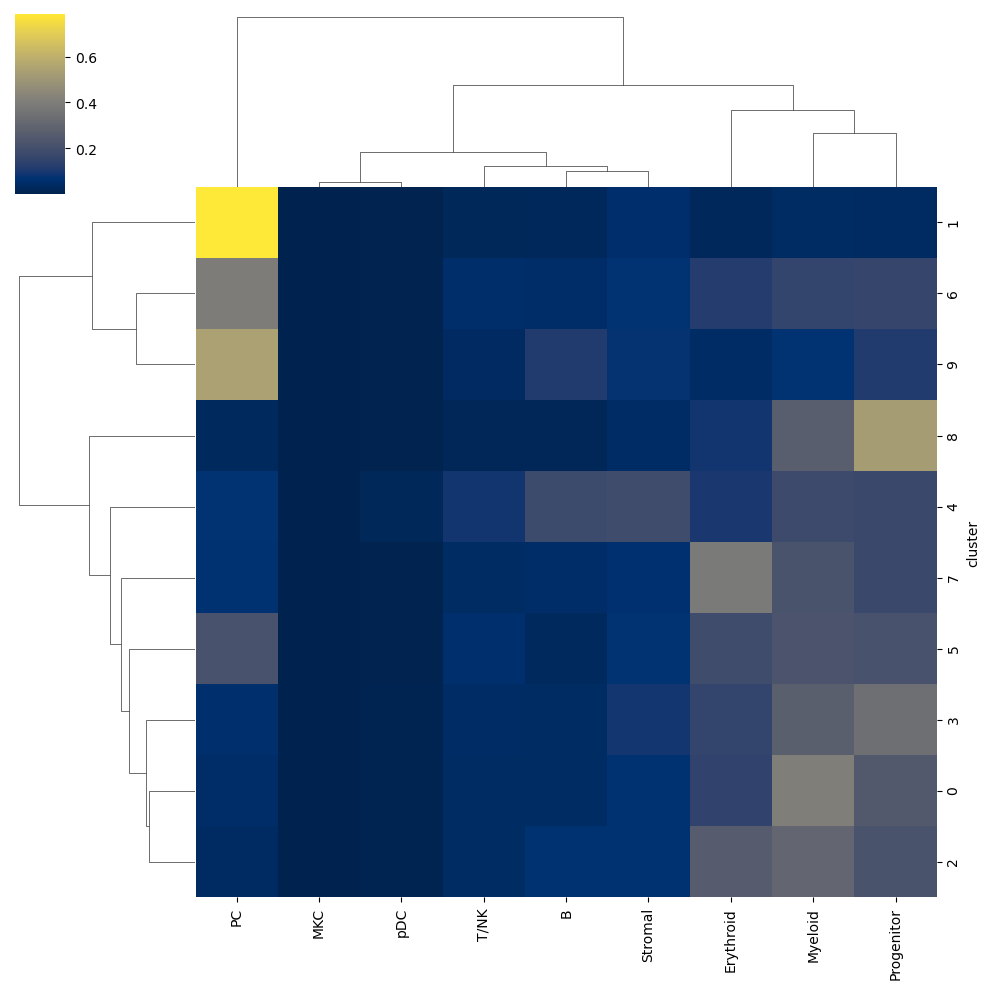

In [37]:
sns.clustermap(grouped, cmap='cividis')
plt.savefig(output_dir / 'clusters_heatmap_fractions.svg')

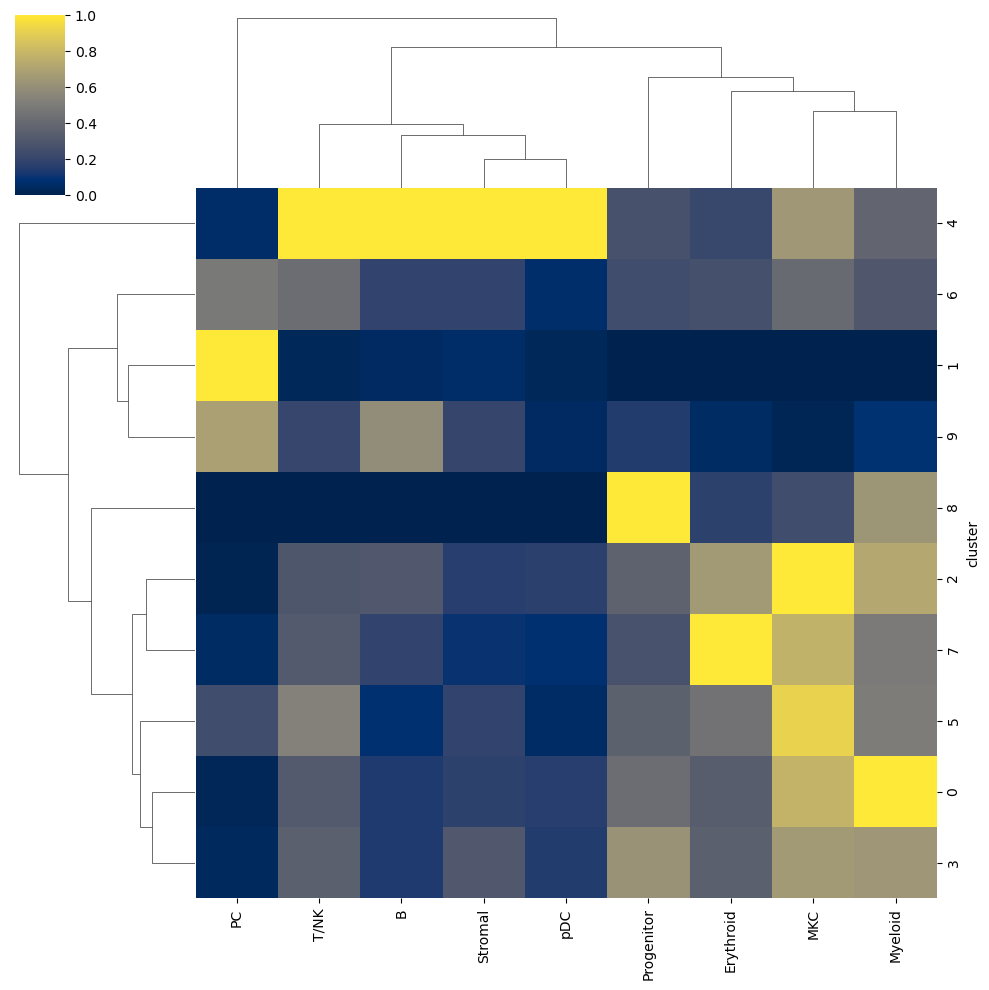

In [38]:
sns.clustermap(grouped, cmap='cividis', standard_scale=1)
plt.savefig(output_dir / 'clusters_heatmap_fractions_scaled.svg')

In [39]:
fractions.to_csv(output_dir / 'all_fractions.txt', sep='\t')
grouped.to_csv(output_dir / 'cluster_mean_fractions.txt', sep='\t')


In [40]:
sids = sorted(set(fractions['sid']))
ncols = 10
nrows = (len(sids) // ncols) + 1
nrows, ncols

(7, 10)

In [44]:
fractions['cluster'] = fractions['cluster'].astype('category')

/diskmnt/Users2/estorrs/tmp/ipykernel_98105/3667355485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fractions['cluster'] = fractions['cluster'].astype('category')


In [54]:
fractions['cluster'].cat.

IRD_S18-30740A1U3_aaaefkpp-1     7
IRD_S18-30740A1U3_aaaekejm-1     7
IRD_S18-30740A1U3_aaaekekb-1     7
IRD_S18-30740A1U3_aaaeonma-1     7
IRD_S18-30740A1U3_aaaflkno-1     5
                                ..
SP120U1-A1-S1Fp1U1_oidolakm-1    2
SP120U1-A1-S1Fp1U1_oieagbcp-1    2
SP120U1-A1-S1Fp1U1_oiebdpfk-1    0
SP120U1-A1-S1Fp1U1_oiebipkn-1    0
SP120U1-A1-S1Fp1U1_oieblcfk-1    2
Length: 5234894, dtype: int8

IRD_S18-30740A1U3
S11-3564A1U1
S13-35096A1U1
S13-47674A1U1
S14-11561A1U1
S14-14053A1U1
S14-14053A1U2
S14-18864-A1U1
S14-22950-A1U1
S14-9876A1U1
S15-15758-A1U1
S16-26183A1U1
S16-30080A1U1
S17-24784A1U1
S17-24784A1U2
S17-32736-A1U1
S17-34578-A1U1
S17-5570A1U1
S18-36373A1U1
S18-461-A1U1
S18-6148A1U1
S19-25371-A1U1
S20-2375-A1U1
S21-1209-A1U1
S21-19998-A1U1Q1
S21-19998-A1U1Q2
S22-3386-A1U1
S24-19138A1U1
SN113R1-Ma1Fd2-2U2
SN126F1-Ma1Fd2-4U3
SN131R1-Ma1Fd2-12U1
SN151R1-Ma1Fd2-2U1
SN154R1-Ma1Fd2-1U1
SN160R1-Ma1Fd2-15U1
SN161R1-Ma1Fd2-3U1
SN169R1-Ma1Fd2-1U1
SN174R1-14U1
SN198R1-Ma1Fd2-1U2
SN200R1-Ma1Fd2-1U2
SN203R1-Ma1Fd2-2U2
SN207R1-Ma1Fd2-1U2
SN209R1-Ma1Fd2-2U2
SN215R1-Ma1Fd2P-1U1
SN218R1-Ma1Fd2-1U1
SN219R1-Ma1Fd2-1U1
SN221R1-Ma1Fd2P-1U1
SN222R1-Ma1Fd2-1U1
SN222R1-Ma1Fd2P-1U1
SN224R1-Ma1Fd2-1U1
SN225R1-Ma1Fd2-1U1
SN227R1-Ma1Fd2-2U1
SN228R1-Ma1Fd2-1U1
SP110U1-A1-S1Fp1U1
SP112U1-A1-S1Fp1U1
SP113U1-A1-S1Fp1U1
SP114U1-A1-S1Fp1U1
SP115U1-A1-S1Fp1U1
SP117U1-A1-S1Fp1U1
SP118U1-A1-S1Fp1U1Q1
SP118U1

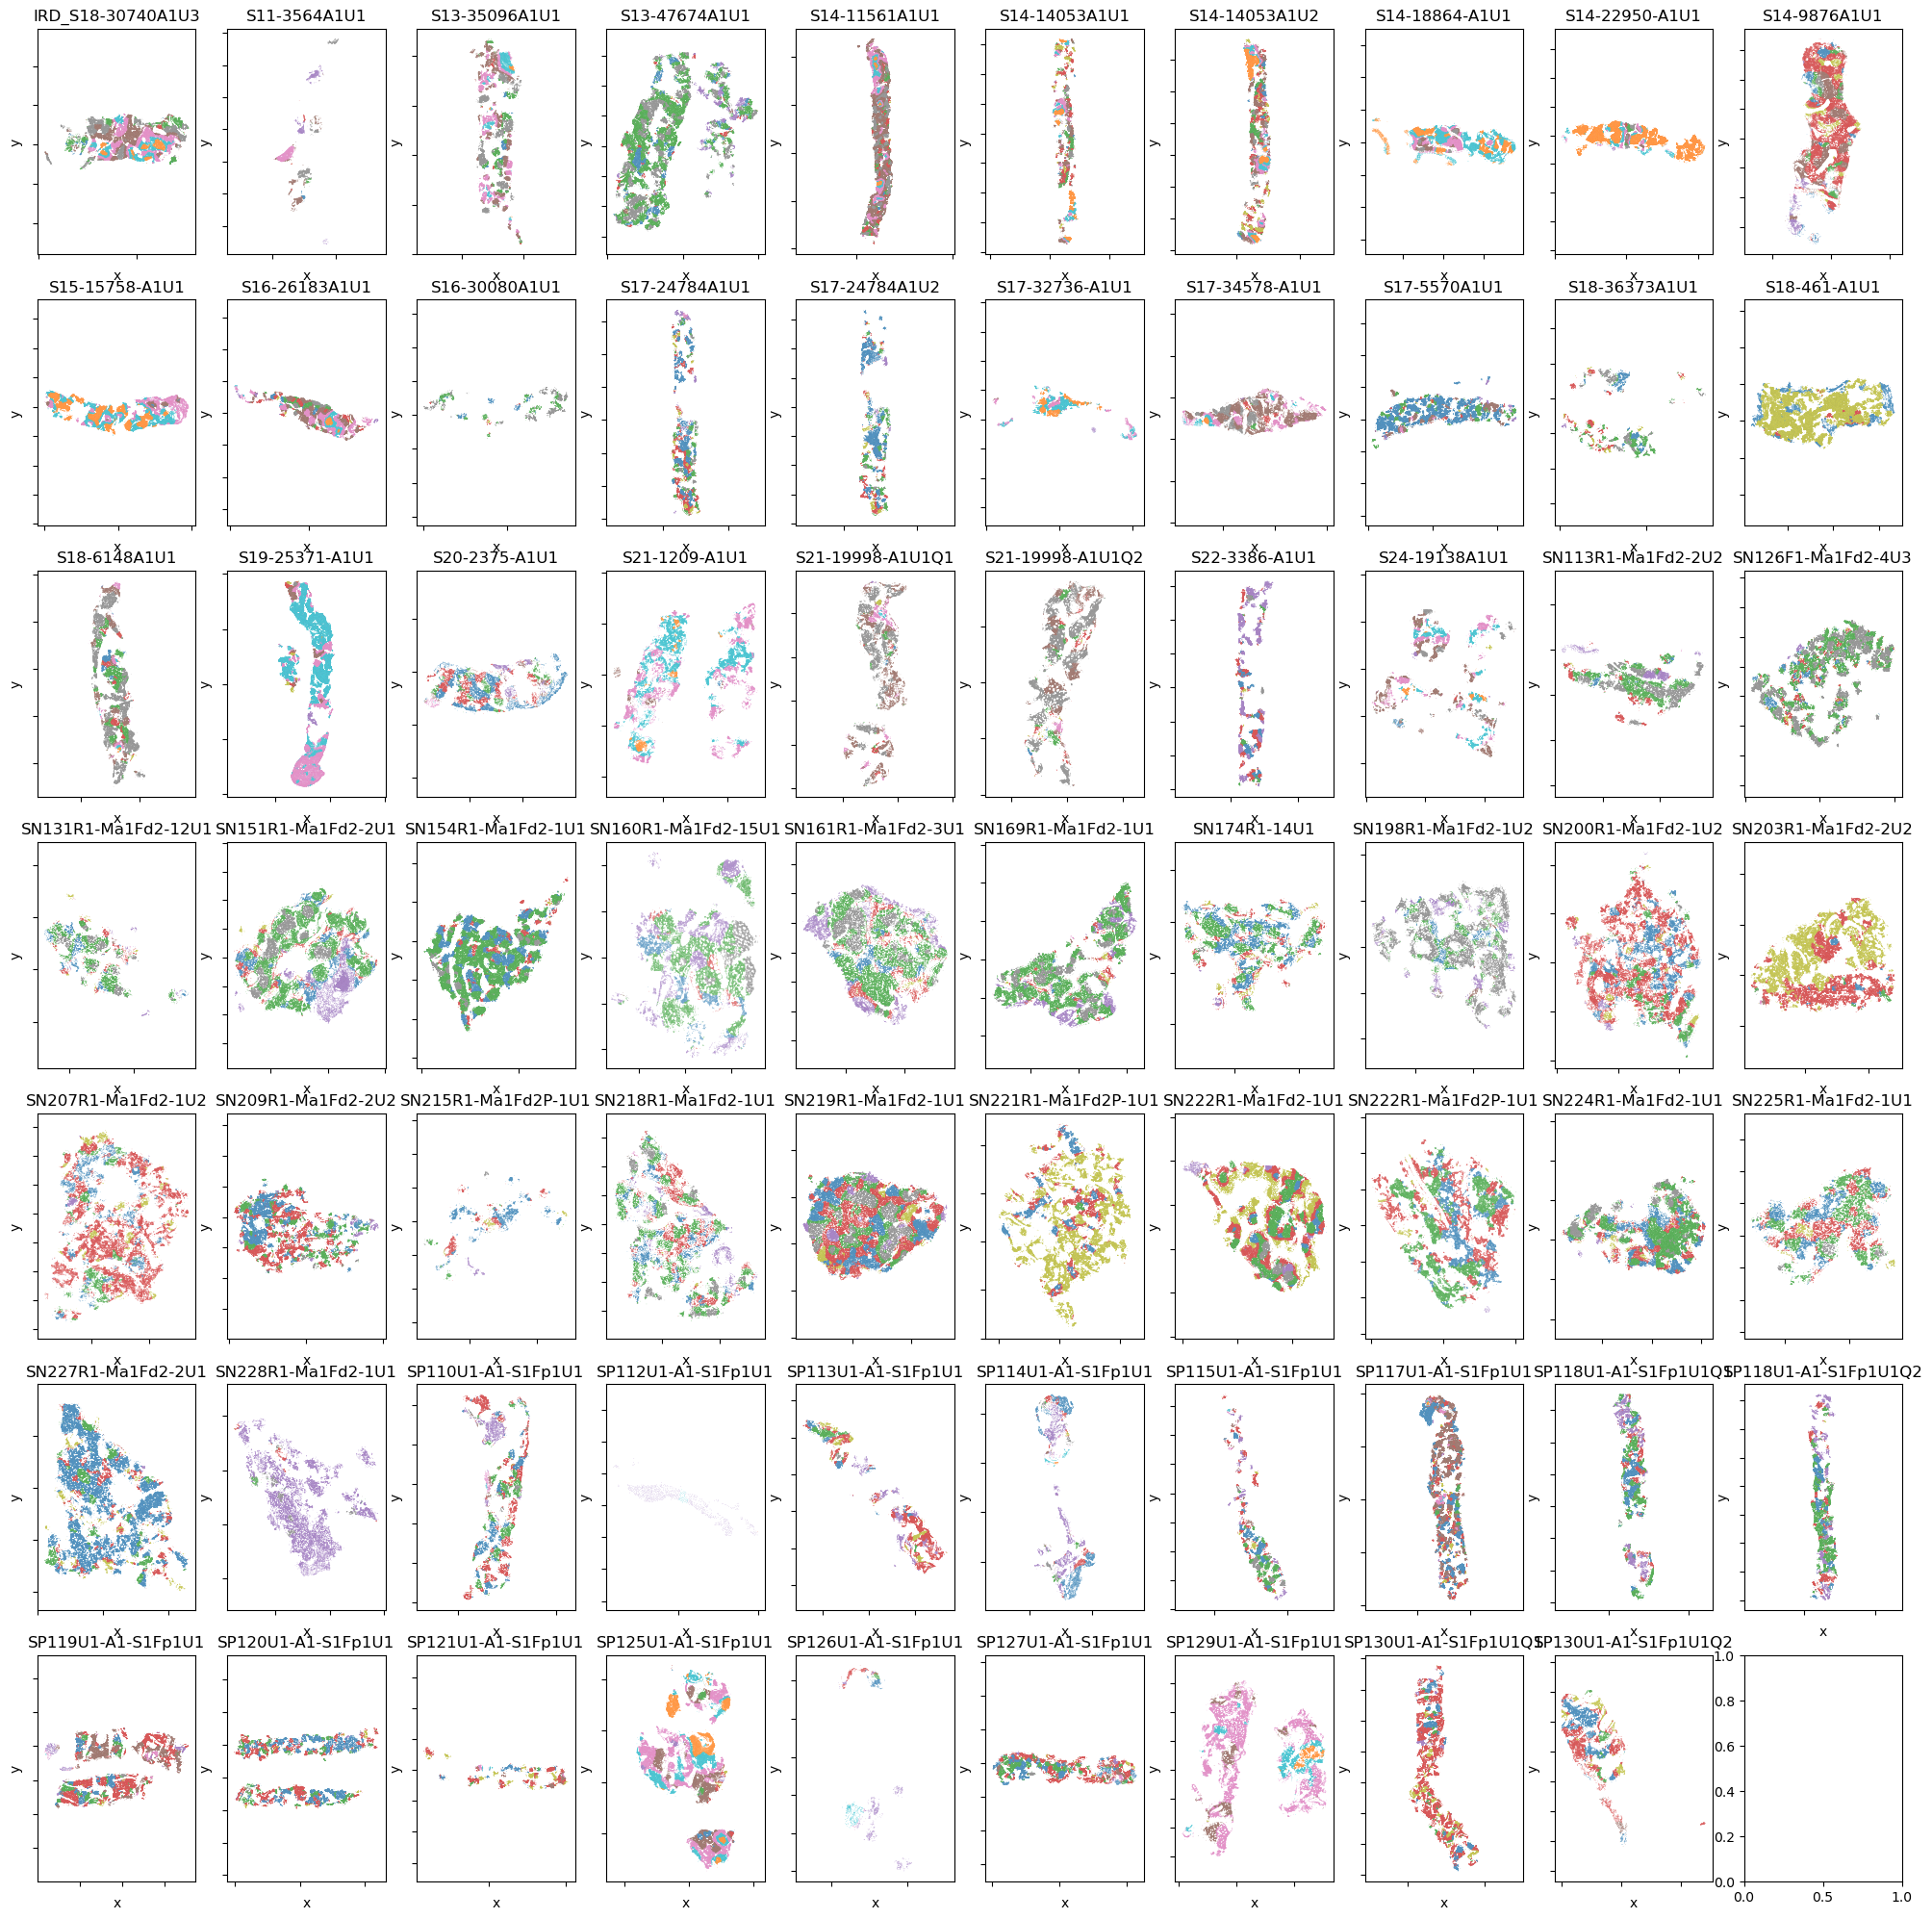

In [56]:
# plot each sample

# colors = np.asarray(sns.color_palette('tab10') + [[0, 0, 0]])
colors = {i:c for i, c in enumerate(sns.color_palette('tab10'))}

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
for sid, ax in zip(sids, axs.flatten()):
    print(sid)
    subset = fractions[fractions['sid']==sid].copy()
    
    sns.scatterplot(subset, x='x', y='y', hue='cluster', s=.1, ax=ax, palette=colors, legend=False)
    ax.axis('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(sid)
    ax.collections[0].set_rasterized(True)

plt.savefig(output_dir / 'clusters.svg')

In [73]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

get average expression for each sample across neighborhoods

In [58]:
# fractions = pd.read_csv(output_dir / 'all_fractions.txt', sep='\t', index_col=0)

# fractions

In [70]:
dfs = []
for sid, row in meta.iterrows():
    print(sid)
    
    subset = fractions[fractions['sid'] == sid]
    barcodes = [x.split('_')[-1] for x in subset.index.to_list()]
    
    spaceranger_dir = Path(row['Output.file.path'])
    
    annotation_df = pd.read_csv(row['annotation_csv'], index_col=0)
    barcode_to_ct = {k:v for k, v in zip(annotation_df.index, annotation_df['group'])}
    
    adata = sc.read_10x_h5(spaceranger_dir / 'cell_feature_matrix.h5')
    gene_df = pd.DataFrame(data=adata.X.toarray(), columns=adata.var.index, index=adata.obs.index)
    gene_df = gene_df.loc[barcodes]

    gene_df['cluster'] = subset['cluster'].values
    gene_df['cell_type'] = [barcode_to_ct.get(barcode) for barcode in gene_df.index]
    gene_df['cluster'] = gene_df['cluster'].astype(int)
    means = gene_df.groupby(['cell_type', 'cluster']).mean().reset_index()
    means.insert(0, 'sid', sid)
    means.index = [f'{sid}_{cluster}_{ct}' for sid, cluster, ct in means[['sid', 'cluster', 'cell_type']].values]
    dfs.append(means)
exp = pd.concat(dfs)
exp

IRD_S18-30740A1U3
ERROR! Session/line number was not unique in database. History logging moved to new session 1076
S11-3564A1U1
S13-35096A1U1
S13-47674A1U1
S14-11561A1U1
S14-14053A1U1
S14-14053A1U2
S14-18864-A1U1
S14-22950-A1U1
S14-9876A1U1
S15-15758-A1U1
S16-26183A1U1
S16-30080A1U1
S17-24784A1U1
S17-24784A1U2
S17-32736-A1U1
S17-34578-A1U1
S17-5570A1U1
S18-36373A1U1
S18-461-A1U1
S18-6148A1U1
S19-25371-A1U1
S20-2375-A1U1
S21-1209-A1U1
S21-19998-A1U1Q1
S21-19998-A1U1Q2
S22-3386-A1U1
S24-19138A1U1
SN113R1-Ma1Fd2-2U2
SN126F1-Ma1Fd2-4U3
SN131R1-Ma1Fd2-12U1
SN151R1-Ma1Fd2-2U1
SN154R1-Ma1Fd2-1U1
SN160R1-Ma1Fd2-15U1
SN161R1-Ma1Fd2-3U1
SN169R1-Ma1Fd2-1U1
SN174R1-14U1
SN198R1-Ma1Fd2-1U2
SN200R1-Ma1Fd2-1U2
SN203R1-Ma1Fd2-2U2
SN207R1-Ma1Fd2-1U2
SN209R1-Ma1Fd2-2U2
SN215R1-Ma1Fd2P-1U1
SN218R1-Ma1Fd2-1U1
SN219R1-Ma1Fd2-1U1
SN221R1-Ma1Fd2P-1U1
SN222R1-Ma1Fd2-1U1
SN222R1-Ma1Fd2P-1U1
SN224R1-Ma1Fd2-1U1
SN225R1-Ma1Fd2-1U1
SN227R1-Ma1Fd2-2U1
SN228R1-Ma1Fd2-1U1
SP110U1-A1-S1Fp1U1
SP112U1-A1-S1Fp1U1
SP113U1

,sid,cell_type,cluster,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,...,SF3B1_pK700E_ALT_C,SF3B1_pK700E_WT,STAT1,STAT3,STAT5A,TNFRSF10B,TNFRSF13C,TNFSF13,TNFSF13B,ZBTB38
IRD_S18-30740A1U3_0_B,IRD_S18-30740A1U3,B,0,0.000000,0.000000,0.000000,0.000000,0.085714,0.114286,0.057143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IRD_S18-30740A1U3_1_B,IRD_S18-30740A1U3,B,1,0.000000,0.000000,0.000000,0.027397,0.150685,0.000000,0.013699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IRD_S18-30740A1U3_2_B,IRD_S18-30740A1U3,B,2,0.000000,0.005988,0.014970,0.008982,0.095808,0.050898,0.014970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IRD_S18-30740A1U3_3_B,IRD_S18-30740A1U3,B,3,0.000000,0.000000,0.025641,0.025641,0.076923,0.025641,0.051282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IRD_S18-30740A1U3_5_B,IRD_S18-30740A1U3,B,5,0.002081,0.013528,0.008325,0.010406,0.115505,0.048907,0.009365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP130U1-A1-S1Fp1U1Q2_0_pDC,SP130U1-A1-S1Fp1U1Q2,pDC,0,0.007812,0.007812,0.031250,0.007812,0.289062,0.179688,0.015625,...,0.000000,0.070312,0.289062,0.468750,0.203125,0.039062,0.164062,0.179688,0.148438,0.085938
SP130U1-A1-S1Fp1U1Q2_2_pDC,SP130U1-A1-S1Fp1U1Q2,pDC,2,0.111111,0.000000,0.000000,0.000000,0.555556,0.000000,0.000000,...,0.111111,0.111111,0.111111,0.222222,0.111111,0.000000,0.000000,0.222222,0.000000,0.000000
SP130U1-A1-S1Fp1U1Q2_3_pDC,SP130U1-A1-S1Fp1U1Q2,pDC,3,0.000000,0.000000,0.018182,0.018182,0.290909,0.072727,0.036364,...,0.000000,0.054545,0.272727,0.272727,0.290909,0.018182,0.363636,0.163636,0.127273,0.054545
SP130U1-A1-S1Fp1U1Q2_5_pDC,SP130U1-A1-S1Fp1U1Q2,pDC,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
exp.to_csv(output_dir / 'cluster_expression.txt', sep='\t', index=False)

In [72]:
(output_dir / 'cluster_expression.txt').absolute()

PosixPath('/diskmnt/Users2/estorrs/ding-lab-spatial/notebooks/../data/cell_type_grid_analysis_for_julia_v2/cluster_expression.txt')